In [2]:
from matplotlib import pyplot as plt
import math
import numpy as np
from tqdm import tqdm
import random
import seaborn as sns
import random

In [3]:
class Brownian():
    def __init__(self, s0) -> None:
        self.s0 = s0

    def stock_price(
        self,
        mu_fn = lambda x: 1,
        sigma_fn = lambda x: 1,
        deltaT = 52,
        dt = 0.1):
        
        # for n time steps
        n_timesteps = int(deltaT/dt)

        # np array of values
        S = np.zeros(n_timesteps+1)
        # Set first timestep to s0
        S[0] = self.s0

        # Generate sigma and mu vectors
        # range between 0,1 incremented by n_timesteps
        mu_vec = np.array([mu_fn(x/n_timesteps) for x in range(n_timesteps)])
        sigma_vec = np.array([sigma_fn(x/n_timesteps) for x in range(n_timesteps)])

        for t in range(n_timesteps):
            # generate noise 

            # get prev time step (s0 is index 0)
            s = S[t]
            mu = mu_vec[t]
            sig = sigma_vec[t]

            dW = np.random.normal(0,math.sqrt(dt))
            ds = mu*dt*s + sig*s*dW
            S[t+1] = s + ds
        
        # Return vals, not including s0
        return S

In [4]:
class Drift(Brownian):
    def __init__(self, deltaT, dt, s0, musig) -> None:
        """
        Params:
        dT - Duration, for plug and play with BSE
        metadata - Metadata for the drift
        stock price generates GBM with drift using 
        functions defined below.
        """
        
        # Get the total number of time steps
        super().__init__(s0=s0)
        self.n_steps = int(deltaT/dt)

        self.gbm_offset_vec = self.stock_price(deltaT=deltaT,dt=dt,mu_fn=musig.mu,sigma_fn=musig.sig)
        
    def dump_offset(self, path):
        np.save(path, np.array(self.gbm_offset_vec))

    def offset_fn(self, t):
        """
        Returns the offset 
        """
        try:
            offset = self.gbm_offset_vec[math.floor(t/self.dt)]
            return int(round(offset, 0))
        except:
            # If time IDX is clipped return the last value at the end
            print('WARNING: schedule offset clipped')
            return int(round(self.gbm_offset_vec[-1],0))

100%|██████████| 100/100 [00:00<00:00, 186.14it/s]


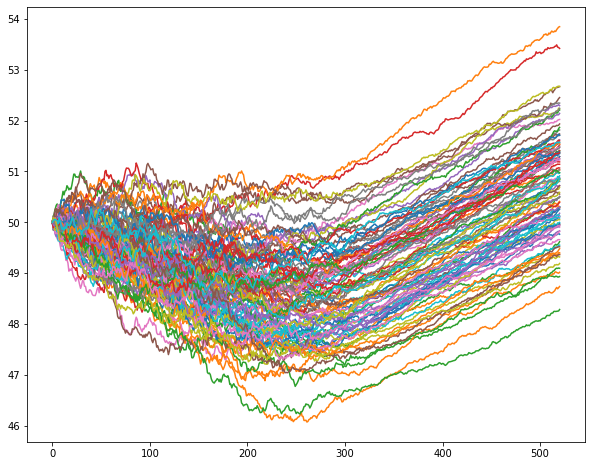

(50.79533567114105, 1.0300411593036167)

In [5]:
class MuSigma:
    """
    Problems:
    Drift parameters are not normalised for the time scale, this means
    it can only be used for tested time frames
    """
    def __init__(self):
        self.meta_data = {
            'drift_type': 'gradual',
            'drift_times': [0.30, 0.65],
            'params_varied': ['mu','sigma'],
        }

    def mu(t):
        x1 = -0.0015
        x2 = 0.0020
        t1 = 0.3
        t2 = 0.65

        if t < t1:
            return x1
        elif t1 <= t <= t2:
            # Linear Increase
            m = (((x2-x1)/(t2-t1))*(t-t1))+x1
            return m
        else:
            return x2

    def sig(t):
        x1 = 0.0040
        x2 = 0.0010
        t1 = 0.3
        t2 = 0.65

        if t < t1:
            return x1
        elif t1 <= t <= t2:
            # Linear increase
            m = (((x2-x1)/(t2-t1))*(t-t1))+x1
            return m
        else:
            return x2


ep = np.zeros(100)
fig,ax = plt.subplots(figsize=(10,8))
for i in tqdm(range(100)):
    pcx = Drift(musig=MuSigma, s0=50, deltaT=52, dt=0.1).gbm_offset_vec
    plt.plot(pcx)
    ep[i] = pcx[-1]
    
plt.show()
fig.savefig('./fig.png',dpi=300.0)
np.mean(ep), np.std(ep)

Using pickle may not be appropriate

Instead, create python scripts containing classes

Easier to maintain as well

Can pickle in BSE for passing around CPUs

Perhaps drift generation could be automated??